<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S7-Assignment/EVA_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [5]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
%matplotlib inline
import random # for random image index


from tqdm import tqdm # for beautiful model training updates
# from model import Network

Seed and Cuda

In [3]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : False


### 1. Loading Data



In [7]:
## downloading training data, using this to calculate mean and standard deviation 

train_mean_std_dev = datasets.CIFAR10(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.ToTensor()# converts to tesnor
    )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [25]:
train_mean_std_dev.data.shape  ## looking at the shape of the data

(50000, 32, 32, 3)

In [15]:
# Getting Mean and Standard Deviation of CIFAR 10 dataset
def get_mean_std_dev(dataset):
  '''
  reference : https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
  '''

  data = dataset.data / 255 # data is numpy array

  mean = data.mean(axis = (0,1,2)) 
  std = data.std(axis = (0,1,2))
  # print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]
  return tuple(mean), tuple(std)



mean, std_dev = get_mean_std_dev(train_mean_std_dev)
print(f"Mean : {mean}   STD: {std_dev}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]


Mean : (0.4913996786152028, 0.4821584083946074, 0.4465309144454644)   STD: (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std_dev)])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Visualizing Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   car  frog  deer


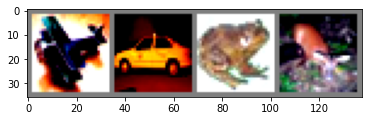

In [23]:
import matplotlib.pyplot as plt # for visualizing images
import numpy as np
import torchvision

def imshow(img):
  '''
  function to show an image
  '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Network
Defining CNN

In [11]:
import torch
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method

drop_out_value = 0.1

class Network(nn.Module):
    def __init__(self):
      super(Network,self).__init__() # extending super class method

      # Input block
      self.convblock_input= nn.Sequential(
        nn.Conv2d(3,32,3,padding=1), # In- 3x32x32, Out- 32x30x30, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # CONV BLOCK 1
      self.convblock1 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1), # In- 32x30x30, Out- 32x28x28, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1), # In- 32x28x28, Out- 32x26x26, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )

      # TRANSITION BLOCK 1
      # STRIDED CONVOLUTION LAYER
      self.transitionblock1 = nn.Sequential(
        nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x26x26, Out- 32x12x12, RF- 9x9, Jump_in -1, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # CONV BLOCK 2
      # Depthwise Separable Convolution Layer
      self.convblock2 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1,groups=32),# In- , Out- , RF- 13x13, Jump_in -2, Jump_out -2
        nn.Conv2d(32,32,1,padding=0), # In- , Out- , RF- 13x13, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1), # In- , Out- , RF- 17x17, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # TRANSITION BLOCK 2
      # STRIDED CONVOLUTION LAYER
      self.transitionblock2 = nn.Sequential(
        nn.Conv2d(32,32,3,stride=2,padding=1), # In- , Out- , RF- 21x21, Jump_in -2, Jump_out -4
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
        
      
      # CONV BLOCK 3
      # Dilated Convolution Layer
      self.convblock3 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1,dilation=2),# In- , Out- , RF- 29x29, Jump_in -4, Jump_out -4
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1), # In- , Out- , RF- 37x37, Jump_in -4, Jump_out -4
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # TRANSITION BLOCK 3
      # STRIDED CONVOLUTION LAYER
      self.transitionblock3 = nn.Sequential(
        nn.Conv2d(32,32,3,stride=2,padding=1), # In- , Out- , RF- 45x45, Jump_in -4, Jump_out -8
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )   

      # CONV BLOCK 4
      # Depthwise Separable Convolution Layer
      self.convblock4 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1), # In- , Out- , RF- 61x61, Jump_in -8, Jump_out -8
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1,groups=32), # In- , Out- , RF- 77x77, Jump_in -8, Jump_out -8
        nn.Conv2d(32,10,1,padding=0) # In- , Out- , RF- 77x77, Jump_in -8, Jump_out -8
        # , 
        # nn.ReLU(),
        # nn.BatchNorm2d(10),
        # nn.Dropout(drop_out_value)
        )
      
      # Output BLOCK 
      # GAP Layer
      self.gap = nn.AvgPool2d(3)


    def forward(self, x):
      x = self.convblock_input(x)
      x = self.convblock1(x)
      x = self.transitionblock1(x)
      x = self.convblock2(x)
      x = self.transitionblock2(x)
      x = self.convblock3(x)
      x = self.transitionblock3(x)
      x = self.convblock4(x)
      x = self.gap(x)

      x = x.view(-1, 10)

      return F.log_softmax(x, dim=1)

#### Model Params
Checking the model summary and number of parameters


In [12]:
device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Network().to(device)
# print(model)

# !pip install torchsummary
from torchsummary import summary # for model summary and params
summary(model, input_size=(3, 32, 32))


cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim # for optimizer


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.185
[1,  4000] loss: 1.848
[1,  6000] loss: 1.678
[1,  8000] loss: 1.573
[1, 10000] loss: 1.524
[1, 12000] loss: 1.480
[2,  2000] loss: 1.399


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))